# Etap 1 - pozyskanie danych.

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import shutil

from dask.diagnostics import ProgressBar
from distributed import Client
import seaborn as sns
import matplotlib.pyplot as plt
import dask.bag as db
import gc
from dask_ml.model_selection import train_test_split, GridSearchCV
from dask_ml.preprocessing import LabelEncoder

import dask.array as da
import pickle

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


base_path = './project_data/parquet'
os.makedirs(base_path, exist_ok=True)

In [2]:
client = Client(n_workers=4, memory_limit='8GB',threads_per_worker=2)
n_partition = 50
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50955,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:50978,Total threads: 2
Dashboard: http://127.0.0.1:50980/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:50958,


## Pobranie danych

In [3]:
folder_path = 'project_data/stocks/'
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

bag = db.from_sequence(csv_files)
bag = bag.map(lambda file: dd.read_csv(file).assign(Stock_Type=os.path.basename(file).replace('.csv', '')))

In [4]:
dfs = bag.compute()
combined_df = dd.concat(dfs, axis=0)

combined_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock_Type,Adj Close
0,1962-01-02 00:00:00-05:00,0.0,1.503273,1.494699,1.494699,55930,0.0,0.0,AA,<NA>
1,1962-01-03 00:00:00-05:00,1.494699,1.517562,1.491841,1.517562,74906,0.0,0.0,AA,<NA>
2,1962-01-04 00:00:00-05:00,1.517562,1.528994,1.517562,1.517562,80899,0.0,0.0,AA,<NA>
3,1962-01-05 00:00:00-05:00,1.517562,1.526136,1.511847,1.514704,70911,0.0,0.0,AA,<NA>
4,1962-01-08 00:00:00-05:00,1.508989,1.508989,1.45183,1.463262,93883,0.0,0.0,AA,<NA>


In [5]:
combined_df.dtypes

Date            string[pyarrow]
Open                     object
High                     object
Low                      object
Close                    object
Volume                   object
Dividends               float64
Stock Splits            float64
Stock_Type               object
Adj Close       string[pyarrow]
dtype: object

In [6]:
del csv_files
del dfs

# Etap 2 - analiza eksploracyjna i preprocessing danych.

## Analiza podstawowych statystyk

In [7]:
dask_df = combined_df.copy()
dask_df = dask_df.persist()

In [8]:
dask_df.describe().compute()

,Dividends,Stock Splits
count,8.535407e+06,8.535407e+06
mean,3.140786e-03,6.217332e-04
std,3.643578e-01,3.555194e-02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.000000e+03,1.243000e+01


In [9]:
dask_df = dask_df.astype({
    "Open": "float64",
    "High": "float64",
    "Low": "float64",
    "Close": "float64",
    "Volume": "float64"
})
dask_df.dtypes

Date            string[pyarrow]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                  float64
Dividends               float64
Stock Splits            float64
Stock_Type               object
Adj Close       string[pyarrow]
dtype: object

## Analiza brakujących danych

### Szukanie brakujących wartości 

In [10]:
missing_data = dask_df.isnull().sum().compute()
missing_data

Date                  0
Open                  1
High                  1
Low                   1
Close                 1
Volume                0
Dividends             0
Stock Splits          0
Stock_Type            0
Adj Close       8535407
dtype: int64

### Działania na brakujących wartościach

In [11]:
record_number = len(dask_df)

for column, value in missing_data.items():
    if value > 0:
        if value / record_number > 0.3:
            dask_df = dask_df.drop(column, axis=1)
        elif dask_df[column].dtype == 'string[pyarrow]':
            # Usunięcie tylko rekordów, które zawierają braki w kolumnach typu string
            dask_df = dask_df.dropna(subset=[column])
        else:
            if dask_df[column].dtype == 'float64':
                mean_value = dask_df[column].mean()
                dask_df[column] = dask_df[column].fillna(mean_value)
            elif dask_df[column].dtype == 'int64':
                mean_value = dask_df[column].mean().round().astype('int64')
                dask_df[column] = dask_df[column].fillna(mean_value)

In [12]:
dask_df = dask_df.reset_index(drop=True)
dask_df = dask_df.persist()
dask_df.describe().compute()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,8.535407e+06,8.535407e+06,8.535407e+06,8.535407e+06,8.535407e+06,8.535407e+06,8.535407e+06
mean,2.752770e+01,2.873015e+01,2.791936e+01,2.832380e+01,2.191716e+06,3.140786e-03,6.217332e-04
std,1.421413e+02,1.466794e+02,1.385828e+02,1.425282e+02,1.802394e+07,3.643578e-01,3.555194e-02
min,-6.608854e+02,-6.608857e+02,-6.518325e+02,-6.608857e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.989190e+00,4.274937e+00,4.199787e+00,4.231564e+00,5.440000e+04,0.000000e+00,0.000000e+00
50%,1.314219e+01,1.359538e+01,1.317583e+01,1.339000e+01,5.620000e+05,0.000000e+00,0.000000e+00
75%,3.950135e+01,4.053861e+01,3.931000e+01,3.997683e+01,4.072400e+06,0.000000e+00,0.000000e+00
max,2.836882e+04,2.931381e+04,2.653671e+04,2.784812e+04,7.421641e+09,1.000000e+03,1.243000e+01


In [13]:
missing_data = dask_df.isnull().sum().compute()
missing_data

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Stock_Type      0
dtype: int64

In [14]:
dask_df.dtypes

Date            string[pyarrow]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                  float64
Dividends               float64
Stock Splits            float64
Stock_Type               object
dtype: object

## Zapis danych do parquet

In [15]:
output_path = os.path.join(base_path, 'raw_data')
os.makedirs(output_path, exist_ok=True)
with ProgressBar():
    dask_df.to_parquet(output_path ,name_function=lambda x: f"data-{x}.parquet", engine='pyarrow')

## Wczytanie danych z parquet do Dask DataFrame

In [16]:
dask_df = dd.read_parquet(output_path, engine='pyarrow')
dask_df = dask_df.repartition(npartitions=n_partition)
dask_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock_Type
0,1962-01-02 00:00:00-05:00,0.000000,1.503273,1.494699,1.494699,55930.0,0.0,0.0,AA
1,1962-01-03 00:00:00-05:00,1.494699,1.517562,1.491841,1.517562,74906.0,0.0,0.0,AA
2,1962-01-04 00:00:00-05:00,1.517562,1.528994,1.517562,1.517562,80899.0,0.0,0.0,AA
3,1962-01-05 00:00:00-05:00,1.517562,1.526136,1.511847,1.514704,70911.0,0.0,0.0,AA
4,1962-01-08 00:00:00-05:00,1.508989,1.508989,1.451830,1.463262,93883.0,0.0,0.0,AA


### Szukanie odstających wartości

In [17]:
pd_dataframe = dask_df.compute()
numeric_columns = pd_dataframe.select_dtypes(include=['number']).columns

outliers = pd.DataFrame(False, index=pd_dataframe.index, columns=numeric_columns)

# Obliczenie IQR dla każdej kolumny numerycznej
for col in numeric_columns:
    Q1 = pd_dataframe[col].quantile(0.25)
    Q3 = pd_dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Granice dla wartości odstających
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Wyznaczenie wartości odstających
    outliers[col] = (pd_dataframe[col] < lower_bound) | (pd_dataframe[col] > upper_bound)

outliers

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
9147,False,False,False,False,False,False,False
9148,False,False,False,False,False,False,False
9149,False,False,False,False,False,False,False
9150,False,False,False,False,False,False,False


In [18]:
outliers_count = outliers.sum()
outliers_count

Open             851937
High             868503
Low              871523
Close            869698
Volume          1163197
Dividends        103077
Stock Splits       3128
dtype: int64

### Naprawa odstających wartości - zamiana na średnią

In [19]:
means = pd_dataframe[numeric_columns].mean()
for col in numeric_columns:
    # Maska logiczna dla wartości odstających w danej kolumnie
    mask = outliers[col]
    if pd_dataframe[col].dtype == np.float64:
        pd_dataframe.loc[mask, col] = means[col]
    else:
        pd_dataframe.loc[mask, col] = int(round(means[col]))

del outliers  
del mask
del means

pd_dataframe

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock_Type
0,1962-01-02 00:00:00-05:00,0.000000,1.503273,1.494699,1.494699,55930.0,0.0,0.0,AA
1,1962-01-03 00:00:00-05:00,1.494699,1.517562,1.491841,1.517562,74906.0,0.0,0.0,AA
2,1962-01-04 00:00:00-05:00,1.517562,1.528994,1.517562,1.517562,80899.0,0.0,0.0,AA
3,1962-01-05 00:00:00-05:00,1.517562,1.526136,1.511847,1.514704,70911.0,0.0,0.0,AA
4,1962-01-08 00:00:00-05:00,1.508989,1.508989,1.451830,1.463262,93883.0,0.0,0.0,AA
...,...,...,...,...,...,...,...,...,...
9147,2025-01-17 00:00:00-05:00,5.900000,5.990000,5.890000,5.970000,2070500.0,0.0,0.0,ZTR
9148,2025-01-21 00:00:00-05:00,6.010000,6.070000,5.990000,6.020000,346500.0,0.0,0.0,ZTR
9149,2025-01-22 00:00:00-05:00,6.050000,6.050000,5.960000,5.970000,413600.0,0.0,0.0,ZTR
9150,2025-01-23 00:00:00-05:00,5.950000,5.970000,5.930000,5.970000,231500.0,0.0,0.0,ZTR


In [20]:
tmp_output_path = os.path.join(base_path, 'tmp_data')
os.makedirs(tmp_output_path, exist_ok=True)
pd_dataframe.to_parquet("./project_data/parquet/tmp_data/tmp.parquet", engine='pyarrow')
del pd_dataframe

In [21]:
dask_df = dd.read_parquet(tmp_output_path, engine='pyarrow')
dask_df = dask_df.repartition(npartitions=n_partition)

dask_df = dask_df.persist()

In [22]:
gc.collect()

5126

## Korelacje

In [23]:
correlation = dask_df.corr(numeric_only=True).compute()
correlation

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Open,1.000000,0.984477,0.984573,0.983838,0.317932,0.010770,-0.004596
High,0.984477,1.000000,0.997000,0.997787,0.303898,0.008588,-0.004292
Low,0.984573,0.997000,1.000000,0.997830,0.302886,0.008708,-0.004464
Close,0.983838,0.997787,0.997830,1.000000,0.303418,0.008642,-0.004372
Volume,0.317932,0.303898,0.302886,0.303418,1.000000,0.009474,0.001134
Dividends,0.010770,0.008588,0.008708,0.008642,0.009474,1.000000,0.008307
Stock Splits,-0.004596,-0.004292,-0.004464,-0.004372,0.001134,0.008307,1.000000


### Wykres korelacji

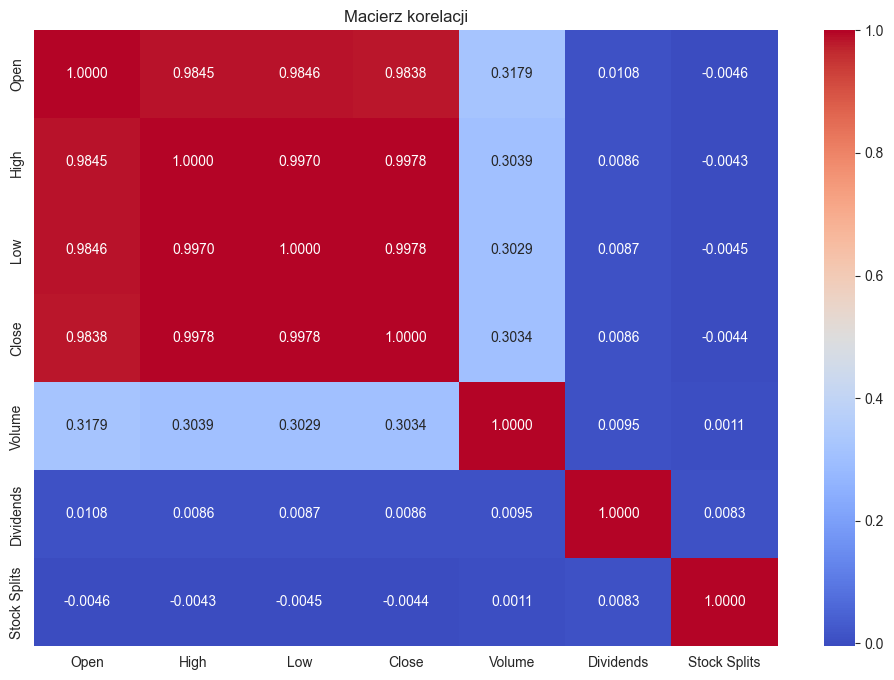

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt='.4f', xticklabels=correlation.columns, yticklabels=correlation.columns)
plt.title("Macierz korelacji")
plt.show()

### Usuwanie kolumn o niskiej korelacji

In [25]:
columns_to_drop = []
for col in correlation.columns:
    max_corr = correlation.loc[correlation.index != col, col].max()
    if max_corr < 0.6:
        columns_to_drop.append(col)

dask_df = dask_df.drop(columns=columns_to_drop)
print(f"Usunięte kolumny: {columns_to_drop}")

Usunięte kolumny: ['Volume', 'Dividends', 'Stock Splits']


## Sprawdzenie typów danych

### Typy danych przed optymalizacją

In [26]:
dask_df.dtypes

Date          string[pyarrow]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Stock_Type    string[pyarrow]
dtype: object

## Optymalizacja typów danych

In [27]:
dask_df = dask_df.persist()

for col in dask_df.select_dtypes(include=['int64']).columns:
    max_value = dask_df[col].max().compute()
    if max_value < 2**31:
        dask_df[col] = dask_df[col].astype('int32')
    elif max_value < 2**63:
        dask_df[col] = dask_df[col].astype('int64')

for col in dask_df.select_dtypes(include=['float64']).columns:
    if dask_df[col].max().compute() < 3.4e38:
        dask_df[col] = dask_df[col].astype('float32')

for col in dask_df.select_dtypes(include=['object']).columns:
    dask_df[col] = dask_df[col].astype('category')
    
dask_df['Stock_Type'] = dask_df['Stock_Type'].astype('category')
dask_df['Date'] = dask_df['Date'].str.replace(r'-\d{2}:\d{2}', '', regex=True)
dask_df['Date'] = dd.to_datetime(dask_df['Date'])

dask_df.compute()
dask_df = dask_df.persist()

### Typy danych po optymalizacji

In [28]:
dask_df.dtypes

Date          datetime64[ns]
Open                 float32
High                 float32
Low                  float32
Close                float32
Stock_Type          category
dtype: object

In [29]:
dask_df.compute()

,Date,Open,High,Low,Close,Stock_Type
0,1962-01-02,0.000000,1.503273,1.494699,1.494699,AA
1,1962-01-03,1.494699,1.517562,1.491841,1.517562,AA
2,1962-01-04,1.517562,1.528994,1.517562,1.517562,AA
3,1962-01-05,1.517562,1.526136,1.511847,1.514704,AA
4,1962-01-08,1.508989,1.508989,1.451830,1.463262,AA
...,...,...,...,...,...,...
9147,2025-01-17,5.900000,5.990000,5.890000,5.970000,ZTR
9148,2025-01-21,6.010000,6.070000,5.990000,6.020000,ZTR
9149,2025-01-22,6.050000,6.050000,5.960000,5.970000,ZTR
9150,2025-01-23,5.950000,5.970000,5.930000,5.970000,ZTR


### Zapis przeanalizowanych danych

In [30]:
analysed_output_path = os.path.join(base_path, 'analysed_data')

In [31]:
os.makedirs(analysed_output_path, exist_ok=True)
dask_df.to_parquet(analysed_output_path, name_function=lambda x: f"data-{x}.parquet", engine='pyarrow')

In [32]:
dask_df = dd.read_parquet(analysed_output_path, engine='pyarrow')
dask_df = dask_df.repartition(npartitions=n_partition)
dask_df = dask_df.persist()
gc.collect()

8606

# Etap 3 - trening modelu ML.

## Wyciagnięcie roku z daty

In [33]:
dask_df['Year'] = dask_df['Date'].dt.year
dask_df.persist()
dask_df.compute()

,Date,Open,High,Low,Close,Stock_Type,Year
0,1962-01-02,0.000000,1.503273,1.494699,1.494699,AA,1962
1,1962-01-03,1.494699,1.517562,1.491841,1.517562,AA,1962
2,1962-01-04,1.517562,1.528994,1.517562,1.517562,AA,1962
3,1962-01-05,1.517562,1.526136,1.511847,1.514704,AA,1962
4,1962-01-08,1.508989,1.508989,1.451830,1.463262,AA,1962
...,...,...,...,...,...,...,...
9147,2025-01-17,5.900000,5.990000,5.890000,5.970000,ZTR,2025
9148,2025-01-21,6.010000,6.070000,5.990000,6.020000,ZTR,2025
9149,2025-01-22,6.050000,6.050000,5.960000,5.970000,ZTR,2025
9150,2025-01-23,5.950000,5.970000,5.930000,5.970000,ZTR,2025


In [34]:
dask_df = dask_df.drop(columns=['Date'])
dask_df.dtypes

Open           float32
High           float32
Low            float32
Close          float32
Stock_Type    category
Year             int32
dtype: object

## Przygotowanie cech i celu

In [35]:
X = dask_df[['Open', 'High', 'Low', 'Year','Stock_Type']]
y = dask_df['Close']
chunks_size = 100000

### Zakodowanie wartosci kategorycznych

In [36]:
encoder = LabelEncoder()
X = X.categorize(columns=['Stock_Type'])

In [37]:
X_encoded = encoder.fit_transform(X[['Stock_Type']].to_dask_array(lengths=True))
X_encoded

dask.array<reshape, shape=(8535407, 1), dtype=int64, chunksize=(170709, 1), chunktype=numpy.ndarray>

### wyznaczenie wartosci numerycznych

In [38]:
X_numeric = X[['Open', 'High', 'Low', 'Year']].to_dask_array(lengths=True)

### Połączenie zbiorów dla x

In [39]:
X_final = da.concatenate([X_numeric, X_encoded], axis=1).rechunk({1: X_numeric.shape[1] + X_encoded.shape[1]})

In [40]:
y_array = y.to_dask_array(lengths=True)

## Podział na zbiór treningowy i testowy

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_array, test_size=0.2, random_state=42)

## Tworzenie modelu

In [42]:
model = Ridge(solver='auto')
model_name = "Ridge"

## Trening modelu

In [43]:
model.fit(X_train, y_train)

Ridge()

# Etap 4 - ewaluacja modelu i jego utrwalenie.

## Serializacja i deserializacja

In [44]:
def serialize_model(path, model, name):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    with open(os.path.join(path, name+'.pkl'), 'wb') as f:
        pickle.dump(model, f)

def deserialize_model(path, name):
    with open(os.path.join(path, name+'.pkl'), 'rb') as f:
        return pickle.load(f)

## Przewidywania na zbiorze testowym oraz sprawdzenie poprawnosci serializacji i deserializacji 

In [45]:
y_pred = model.predict(X_test)

In [46]:
model_output_path = "project_data/model/"

serialize_model(model_output_path, model, model_name)
loaded_model = deserialize_model(model_output_path, model_name)
print("Model załadowany:", loaded_model)

Model załadowany: Ridge()


In [47]:
y_pred_loaded_model = loaded_model.predict(X_test)

In [48]:
original_predictions = y_pred
loaded_model_predictions = y_pred_loaded_model
comparison = (original_predictions == loaded_model_predictions).all()
print(f"Czy prognozy modelu oryginalnego i wczytanego są identyczne? {comparison}")

Czy prognozy modelu oryginalnego i wczytanego są identyczne? True


## Sprawdzanie błędu przewidywań

In [49]:
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

MSE: 0.46755999052024894
RMSE: 0.6837835845647722
R²: 0.9971306473440368


## Wykres rzeczywistych vs przewidywanych wartości

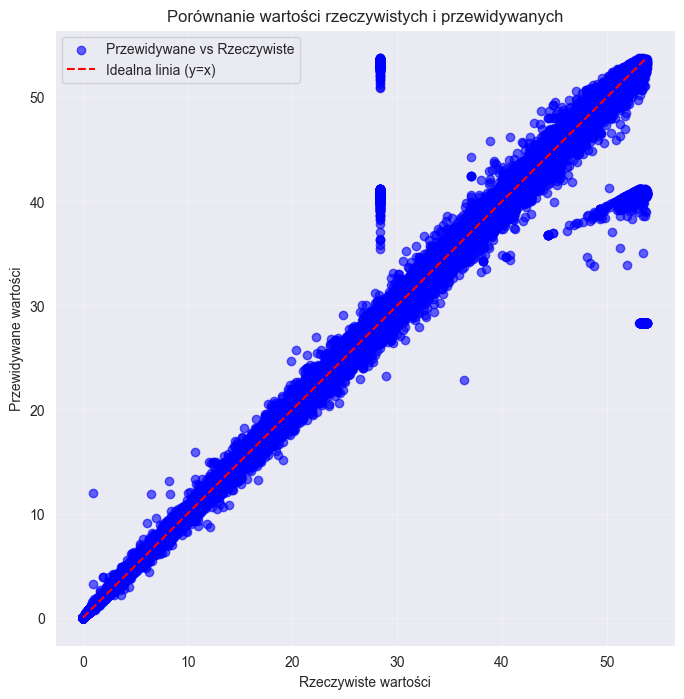

In [50]:
y_test_actual = y_test.compute()
y_predicted = y_pred

plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_predicted, alpha=0.6, color="blue", label="Przewidywane vs Rzeczywiste")
plt.plot([np.min(y_test_actual), np.max(y_test_actual)], 
         [np.min(y_test_actual), np.max(y_test_actual)], 
         color="red", linestyle="--", label="Idealna linia (y=x)")
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Porównanie wartości rzeczywistych i przewidywanych")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

# Szukanie najlepszych parametrów

In [51]:
params = {
    'alpha': np.logspace(-6, 1, num=10), # Wartości regularyzacji
    'fit_intercept': [True, False], # Wyraz wolny
    'tol': [1e-4, 1e-3, 1e-2], # Tolerancja zbieżności
    'max_iter': [1000, 5000, 10000], # Liczba iteracji
    'random_state': [42],  
}

# Tworzenie GridSearchCV
search = GridSearchCV(
    estimator=loaded_model,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=3  # Walidacja krzyżowa
)

In [52]:
search.fit(X_final, y_array)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 5.99484250e-06, 3.59381366e-05, 2.15443469e-04,
       1.29154967e-03, 7.74263683e-03, 4.64158883e-02, 2.78255940e-01,
       1.66810054e+00, 1.00000000e+01]),
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 5000, 10000], 'random_state': [42],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error')

## Najlepsze parametry

In [53]:
search.best_params_

{'alpha': np.float64(1e-06),
 'fit_intercept': True,
 'max_iter': 1000,
 'random_state': 42,
 'tol': 0.0001}

## Najlepszy model

In [54]:
best_model = search.best_estimator_

## Wynik dla najlepszego modelu

In [55]:
accuracy = best_model.score(X_test, y_test)
accuracy

0.9971313610376796

In [56]:
serialize_model(model_output_path, model, model_name+"_best")

In [57]:
client.close()